## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [8]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout


"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(0.3)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(0.3)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [9]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)   

Epoch 46/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.7532 - accuracy: 0.4458 - val_loss: 1.7053 - val_accuracy: 0.4731
Epoch 47/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.7517 - accuracy: 0.4455 - val_loss: 1.7059 - val_accuracy: 0.4732
Epoch 48/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.7487 - accuracy: 0.4498 - val_loss: 1.7053 - val_accuracy: 0.4714
Epoch 49/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.7447 - accuracy: 0.4493 - val_loss: 1.7008 - val_accuracy: 0.4716
Epoch 50/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.7430 - accuracy: 0.4496 - val_loss: 1.7037 - val_accuracy: 0.4753
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
___

Epoch 41/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.5298 - accuracy: 0.5018 - val_loss: 1.4933 - val_accuracy: 0.5160
Epoch 42/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.5263 - accuracy: 0.5032 - val_loss: 1.4939 - val_accuracy: 0.5176
Epoch 43/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.5154 - accuracy: 0.5076 - val_loss: 1.4866 - val_accuracy: 0.5218
Epoch 44/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.5109 - accuracy: 0.5091 - val_loss: 1.4754 - val_accuracy: 0.5202
Epoch 45/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.5074 - accuracy: 0.5107 - val_loss: 1.4784 - val_accuracy: 0.5229
Epoch 46/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.4994 - accuracy: 0.5160 - val_loss: 1.4775 - val_accuracy: 0.5199
Epoch 47/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.4929 - accuracy: 0.5161

Epoch 36/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.4422 - accuracy: 0.4873 - val_loss: 1.4070 - val_accuracy: 0.4963
Epoch 37/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.4313 - accuracy: 0.4920 - val_loss: 1.3832 - val_accuracy: 0.5097
Epoch 38/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.4228 - accuracy: 0.4914 - val_loss: 1.3743 - val_accuracy: 0.5082
Epoch 39/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.4216 - accuracy: 0.4940 - val_loss: 1.3662 - val_accuracy: 0.5161
Epoch 40/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.4118 - accuracy: 0.4997 - val_loss: 1.3622 - val_accuracy: 0.5165
Epoch 41/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.4072 - accuracy: 0.4985 - val_loss: 1.3622 - val_accuracy: 0.5105
Epoch 42/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.4035 - accuracy: 0.4991

Epoch 31/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.4710 - accuracy: 0.4749 - val_loss: 1.4140 - val_accuracy: 0.4907
Epoch 32/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.4649 - accuracy: 0.4808 - val_loss: 1.3905 - val_accuracy: 0.5035
Epoch 33/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.4540 - accuracy: 0.4786 - val_loss: 1.3888 - val_accuracy: 0.5023
Epoch 34/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.4441 - accuracy: 0.4865 - val_loss: 1.3875 - val_accuracy: 0.5031
Epoch 35/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.4433 - accuracy: 0.4852 - val_loss: 1.3910 - val_accuracy: 0.5023
Epoch 36/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.4348 - accuracy: 0.4863 - val_loss: 1.3757 - val_accuracy: 0.5107
Epoch 37/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.4241 - accuracy: 0.4905

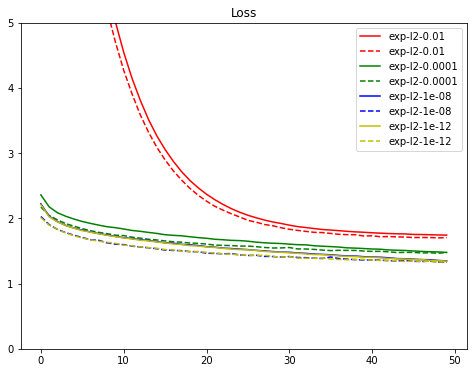

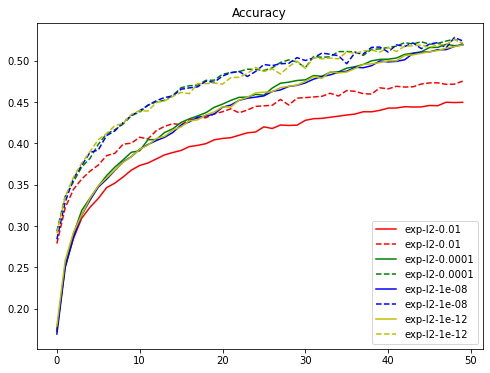

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()